## Defining Helping functions for U-net architecture


### Importing libraries

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Conv3D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import MaxPooling3D
from tensorflow.keras.layers import Conv3DTranspose
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import UpSampling3D
from tensorflow.keras.layers import Concatenate

### Convolution block :-
Number of Conv3D layers is fixed i.e. 2.


In [11]:
def conv_block(input,num_filters):
  x = Conv3D(num_filters,3,padding="same",activation = 'relu')(input)
  x = Conv3D(num_filters,3,padding="same",activation = 'relu')(x)
  return x


**Encoder block :-**\
Pool Size is fixed :2

In [12]:
def encoder_block(input,num_filters):
  x = conv_block(input,num_filters)
  p = MaxPooling3D(pool_size=(2,2,2),strides=(2,2,2))(x)

  return x, p

 Decoder block :-

In [13]:
def decoder_block(input,skip_features,num_filters):
  x = UpSampling3D(size = 1)(input)
  x = Conv3DTranspose(num_filters,(2,2,2),strides=2,padding="same")(x)
  x = Concatenate(axis = 4)([skip_features,x])
  x = conv_block(x,num_filters)
  return x


In [14]:
#Problems
# 1) Doesn't take in account the loss of dimension while downsampling in case of odd size: No logic on when to stop downsampling. --solved
#    Eg:for downsampling=3, 572-286-"143-142"--
# 2) Error in filter size while concatinating after Upsampling. Eg: [?,286,286,286,128], [?,286,286,286,64] --solved
def unet(input_shape,filter_no,no_of_downsamples):
  inputs = Input(input_shape)
  # encoder part
  s=[]#skipped
  p=[]#passed
  a,b = encoder_block(inputs,filter_no)
  s.append(a)
  p.append(b)
  for i in range(no_of_downsamples-1):
    filter_no *= 2
    a,b = encoder_block(p[i],filter_no)
    s.append(a)
    p.append(b)
  filter_no*=2
  # Bridge Part
  b1 = conv_block(p[no_of_downsamples-1],filter_no)

  # Decoder part
  b2 = decoder_block(b1,s[no_of_downsamples-1],filter_no)
  d = []
  d.append(b2)
  for i in range(no_of_downsamples-1):
    c = decoder_block(d[i],s[no_of_downsamples-i-2],filter_no)
    filter_no/=2
    d.append(c)  
  outputs = Conv3D(1,1,padding="same",activation="sigmoid")(d[no_of_downsamples-1])
  model = tf.keras.Model(inputs = inputs, outputs = outputs)
  return model
    


In [20]:
model = unet((96,96,96,3), 64, 4)

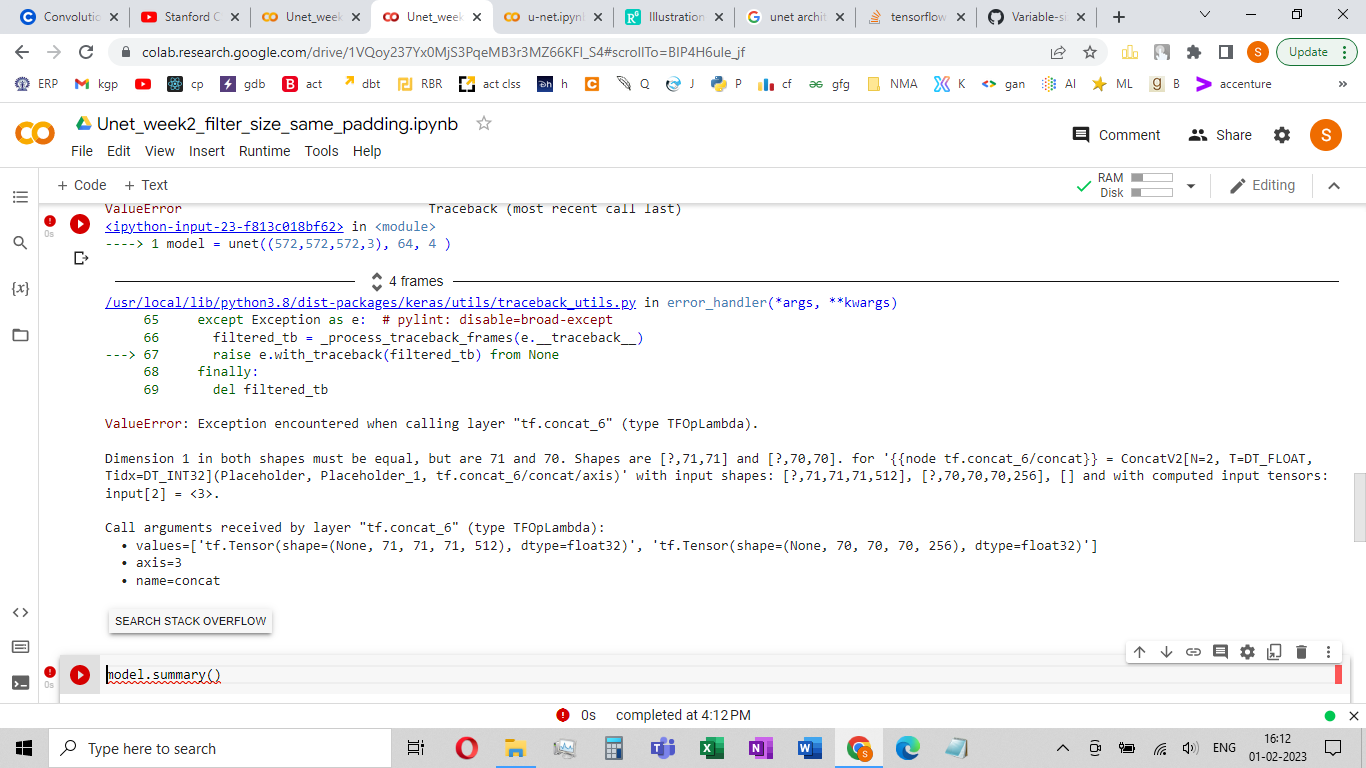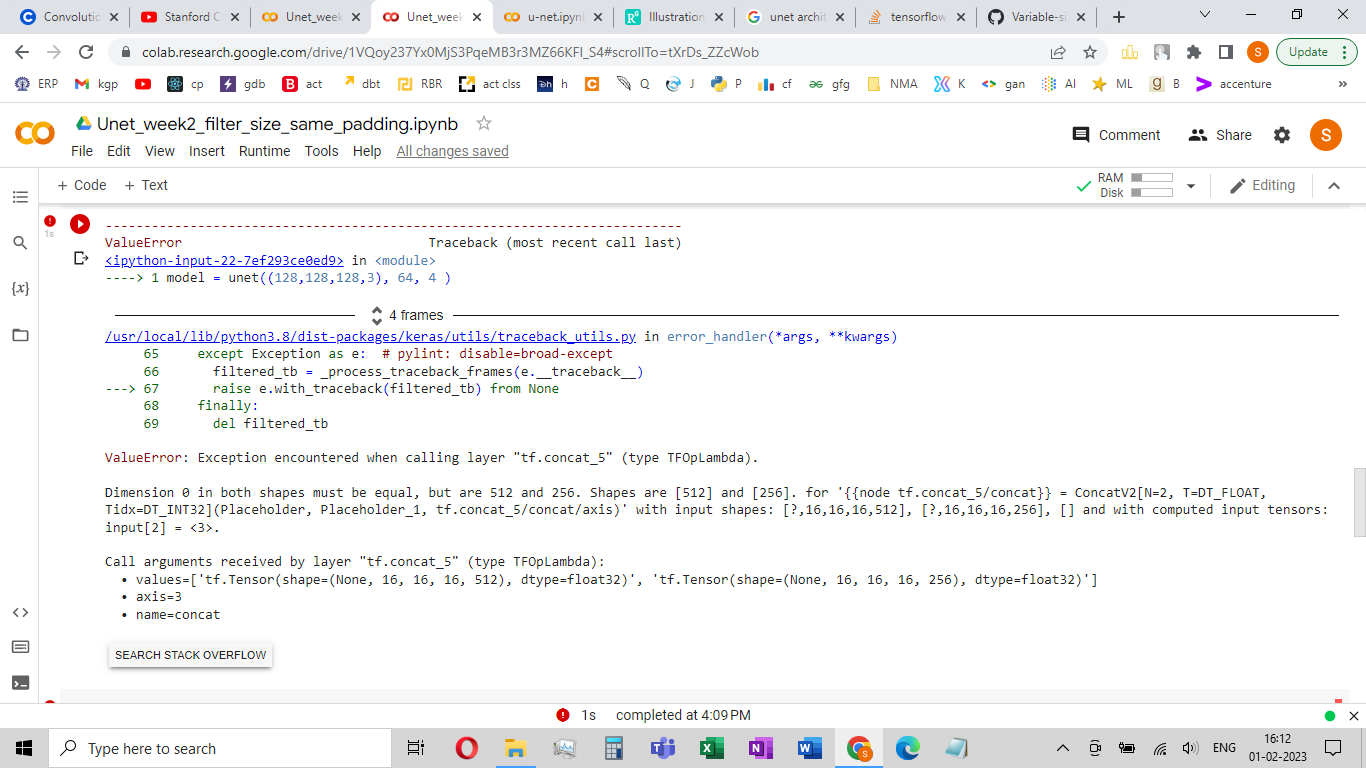

In [16]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 96, 96,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv3d_19 (Conv3D)             (None, 96, 96, 96,   5248        ['input_2[0][0]']                
                                64)                                                               
                                                                                                  
 conv3d_20 (Conv3D)             (None, 96, 96, 96,   110656      ['conv3d_19[0][0]']              
                                64)                                                         

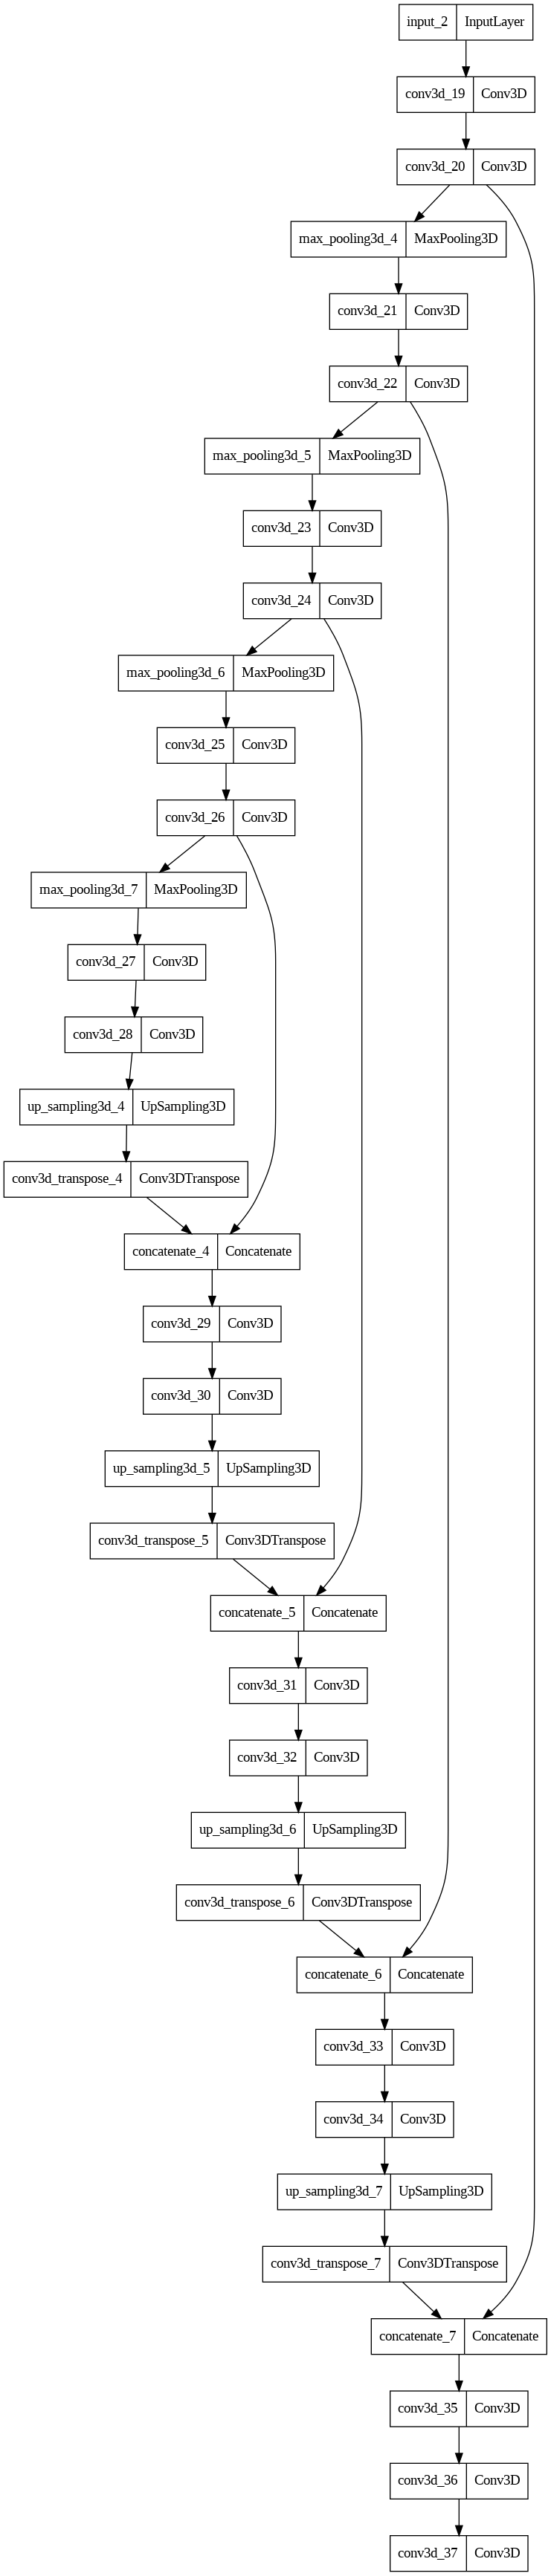

In [17]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False
)

In [18]:
import math
def unet_modified(input_shape,filter_no,no_of_downsamples):
  inputs = Input(input_shape)
  # encoder part
  s=[]#skipped
  p=[]#passed
  a,b = encoder_block(inputs,filter_no)
  s.append(a)
  p.append(b)
  for i in range(no_of_downsamples-1):
    filter_no *= 2
    a,b = encoder_block(p[i],filter_no)
    s.append(a)
    p.append(b)

  # Bridge Part
  b1 = conv_block(p[no_of_downsamples-1],filter_no * 2)

  # Decoder part
  d = []
  # If downsamples<log_2_(input_shape[0]) : 
  for i in range(no_of_downsamples-1):
    c = decoder_block(b1,s[no_of_downsamples-1],filter_no)
    filter_no/=2
    d.append(c)  
  outputs = Conv3D(1,1,padding="same",activation="sigmoid")(d[no_of_downsamples-1])
  model = tf.keras.Model(inputs = inputs, outputs = outputs)
  return model
    
